<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Training_Deep_Neural_Networks_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

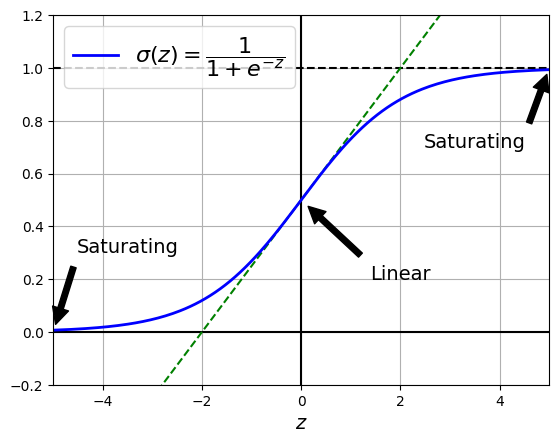

In [3]:
# extra code – this cell generates Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

# Glorot and He Initialization

In [4]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [6]:
import numpy as np

In [7]:
out = np.random.randn(1000) * 9

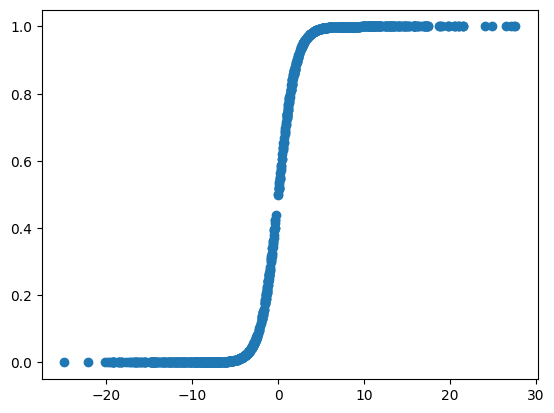

In [8]:
plt.scatter(out, sigmoid(out))

In [9]:
out = np.random.randn(1000) * (3 ** 0.5)

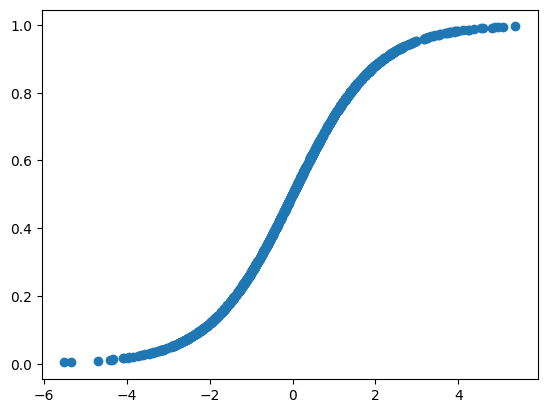

In [10]:
plt.scatter(out, sigmoid(out))

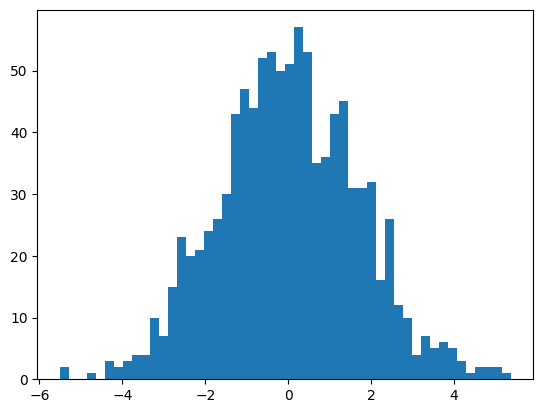

In [11]:
plt.hist(out, bins=50);

In [12]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [13]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

# Better Activation Functions

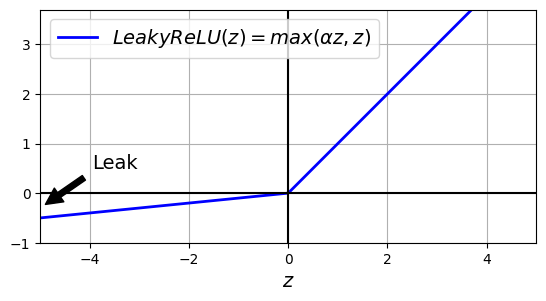

In [14]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [15]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

In [16]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

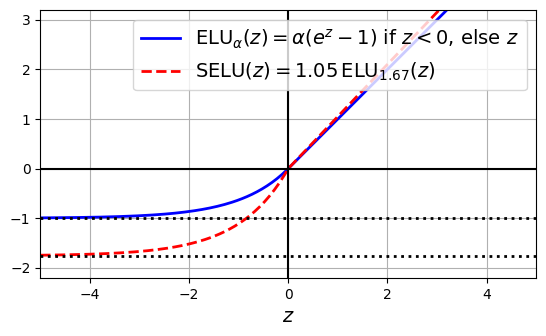

In [17]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [18]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# GELU, Swish, SwiGLU, Mish, and ReLU²

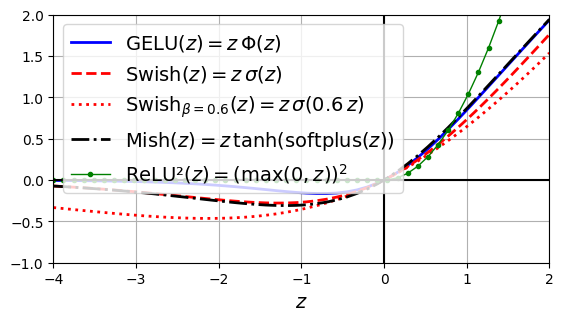

In [19]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

### SwiGLU

In [20]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40), SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### ReLU2

In [21]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

# Batch Normalization

In [22]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [23]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [24]:
dict(model[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var', 'num_batches_tracked'])

In [25]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Layer Normalization

In [26]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions


In [27]:
means = inputs.mean(dim=[2, 3], keepdim=True)
vars_ = inputs.var(dim=[2, 3], keepdim=True, unbiased=False)
stds = torch.sqrt(vars_ + layer_norm.eps)
result2 = layer_norm.weight * (inputs - means) / stds + layer_norm.bias
assert torch.allclose(result, result2)


In [28]:
layer_norm = nn.LayerNorm([3, 100, 200])
result = layer_norm(inputs)  # normalizes over the last three dimensions

### Gradient Clipping

# Reusing Pretrained Layers
### Transfer Learning with PyTorch

In [29]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

In [30]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.9 MB/s eta 0:00:00


In [31]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [32]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

In [33]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

In [34]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [35]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.6363, train metric: 0.7845, valid metric: 0.8390
Epoch 2/20, train loss: 0.3525, train metric: 0.8790, valid metric: 0.8880
Epoch 3/20, train loss: 0.3054, train metric: 0.8943, valid metric: 0.8975
Epoch 4/20, train loss: 0.2811, train metric: 0.9007, valid metric: 0.8320
Epoch 5/20, train loss: 0.2652, train metric: 0.9073, valid metric: 0.8915
Epoch 6/20, train loss: 0.2519, train metric: 0.9125, valid metric: 0.8950
Epoch 7/20, train loss: 0.2397, train metric: 0.9162, valid metric: 0.8910
Epoch 8/20, train loss: 0.2317, train metric: 0.9194, valid metric: 0.9075
Epoch 9/20, train loss: 0.2234, train metric: 0.9224, valid metric: 0.9015
Epoch 10/20, train loss: 0.2149, train metric: 0.9248, valid metric: 0.9040
Epoch 11/20, train loss: 0.2098, train metric: 0.9276, valid metric: 0.9150
Epoch 12/20, train loss: 0.2029, train metric: 0.9286, valid metric: 0.8985
Epoch 13/20, train loss: 0.1982, train metric: 0.9305, valid metric: 0.9210
Epoch 14/20, train lo

In [36]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

In [37]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [38]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 1.1117, train metric: 0.4000, valid metric: 0.5032
Epoch 2/20, train loss: 0.8887, train metric: 0.4000, valid metric: 0.5036
Epoch 3/20, train loss: 0.7477, train metric: 0.4000, valid metric: 0.5181
Epoch 4/20, train loss: 0.6618, train metric: 0.4000, valid metric: 0.5823
Epoch 5/20, train loss: 0.6067, train metric: 0.4500, valid metric: 0.6705
Epoch 6/20, train loss: 0.5684, train metric: 0.6000, valid metric: 0.7588
Epoch 7/20, train loss: 0.5382, train metric: 0.7000, valid metric: 0.8062
Epoch 8/20, train loss: 0.5149, train metric: 0.9000, valid metric: 0.8359
Epoch 9/20, train loss: 0.4962, train metric: 0.9500, valid metric: 0.8512
Epoch 10/20, train loss: 0.4804, train metric: 0.9500, valid metric: 0.8606
Epoch 11/20, train loss: 0.4671, train metric: 0.9500, valid metric: 0.8651
Epoch 12/20, train loss: 0.4553, train metric: 0.9500, valid metric: 0.8697
Epoch 13/20, train loss: 0.4448, train metric: 0.9500, valid metric: 0.8731
Epoch 14/20, train lo

In [39]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.8860, device='cuda:0')

In [40]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

In [41]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [42]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/10, train loss: 0.8847, train metric: 0.4000, valid metric: 0.4723
Epoch 2/10, train loss: 0.7920, train metric: 0.3000, valid metric: 0.4886
Epoch 3/10, train loss: 0.7442, train metric: 0.2000, valid metric: 0.5600
Epoch 4/10, train loss: 0.7154, train metric: 0.4500, valid metric: 0.6145
Epoch 5/10, train loss: 0.6941, train metric: 0.5500, valid metric: 0.6424
Epoch 6/10, train loss: 0.6760, train metric: 0.6500, valid metric: 0.6562
Epoch 7/10, train loss: 0.6594, train metric: 0.7000, valid metric: 0.6733
Epoch 8/10, train loss: 0.6438, train metric: 0.7000, valid metric: 0.6948
Epoch 9/10, train loss: 0.6290, train metric: 0.7000, valid metric: 0.7169
Epoch 10/10, train loss: 0.6148, train metric: 0.7500, valid metric: 0.7434


In [43]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [44]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.6011, train metric: 0.7500, valid metric: 0.7709
Epoch 2/20, train loss: 0.5841, train metric: 0.7500, valid metric: 0.7994
Epoch 3/20, train loss: 0.5680, train metric: 0.7500, valid metric: 0.8247
Epoch 4/20, train loss: 0.5528, train metric: 0.7500, valid metric: 0.8418
Epoch 5/20, train loss: 0.5384, train metric: 0.8000, valid metric: 0.8572
Epoch 6/20, train loss: 0.5246, train metric: 0.8500, valid metric: 0.8711
Epoch 7/20, train loss: 0.5115, train metric: 0.8500, valid metric: 0.8831
Epoch 8/20, train loss: 0.4990, train metric: 0.9500, valid metric: 0.8878
Epoch 9/20, train loss: 0.4871, train metric: 0.9500, valid metric: 0.8964
Epoch 10/20, train loss: 0.4757, train metric: 0.9500, valid metric: 0.9024
Epoch 11/20, train loss: 0.4648, train metric: 0.9500, valid metric: 0.9064
Epoch 12/20, train loss: 0.4544, train metric: 0.9500, valid metric: 0.9100
Epoch 13/20, train loss: 0.4444, train metric: 0.9500, valid metric: 0.9127
Epoch 14/20, train lo

In [45]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9312, device='cuda:0')

### Add MUON Optimizer here

# Optimizers

In [46]:
# extra code – a little function to test an optimizer on Fashion MNIST

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    history = train(model, optimizer, xentropy, accuracy.to(device),
                    train_loader, valid_loader, n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [47]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5710, train metric: 0.7930, valid metric: 0.8436
Epoch 2/10, train loss: 0.4024, train metric: 0.8530, valid metric: 0.8508
Epoch 3/10, train loss: 0.3620, train metric: 0.8669, valid metric: 0.8692
Epoch 4/10, train loss: 0.3366, train metric: 0.8762, valid metric: 0.8702
Epoch 5/10, train loss: 0.3174, train metric: 0.8831, valid metric: 0.8738
Epoch 6/10, train loss: 0.3030, train metric: 0.8870, valid metric: 0.8712
Epoch 7/10, train loss: 0.2906, train metric: 0.8913, valid metric: 0.8772
Epoch 8/10, train loss: 0.2807, train metric: 0.8957, valid metric: 0.8784
Epoch 9/10, train loss: 0.2715, train metric: 0.8978, valid metric: 0.8786
Epoch 10/10, train loss: 0.2622, train metric: 0.9016, valid metric: 0.8710


## Momentum optimization

In [48]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
history_momentum, acc_momentum = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6026, train metric: 0.7829, valid metric: 0.7866
Epoch 2/10, train loss: 0.4777, train metric: 0.8300, valid metric: 0.8430
Epoch 3/10, train loss: 0.4487, train metric: 0.8408, valid metric: 0.8334
Epoch 4/10, train loss: 0.4336, train metric: 0.8457, valid metric: 0.8458
Epoch 5/10, train loss: 0.4053, train metric: 0.8559, valid metric: 0.8426
Epoch 6/10, train loss: 0.3997, train metric: 0.8572, valid metric: 0.8604
Epoch 7/10, train loss: 0.3934, train metric: 0.8586, valid metric: 0.8442
Epoch 8/10, train loss: 0.3789, train metric: 0.8647, valid metric: 0.8556
Epoch 9/10, train loss: 0.3758, train metric: 0.8662, valid metric: 0.8598
Epoch 10/10, train loss: 0.3676, train metric: 0.8689, valid metric: 0.8582


## Nesterov Accelerated Gradient (NAG)

In [49]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9, nesterov=True, lr=0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5486, train metric: 0.8048, valid metric: 0.8118
Epoch 2/10, train loss: 0.4340, train metric: 0.8454, valid metric: 0.8336
Epoch 3/10, train loss: 0.4070, train metric: 0.8564, valid metric: 0.8490
Epoch 4/10, train loss: 0.3842, train metric: 0.8629, valid metric: 0.8656
Epoch 5/10, train loss: 0.3756, train metric: 0.8661, valid metric: 0.8528
Epoch 6/10, train loss: 0.3681, train metric: 0.8690, valid metric: 0.8604
Epoch 7/10, train loss: 0.3570, train metric: 0.8733, valid metric: 0.8580
Epoch 8/10, train loss: 0.3524, train metric: 0.8752, valid metric: 0.8538
Epoch 9/10, train loss: 0.3428, train metric: 0.8764, valid metric: 0.8612
Epoch 10/10, train loss: 0.3372, train metric: 0.8799, valid metric: 0.8566


## AdaGrad

In [50]:
model = build_model()  # extra code
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5605, train metric: 0.8155, valid metric: 0.8612
Epoch 2/10, train loss: 0.3699, train metric: 0.8642, valid metric: 0.8678
Epoch 3/10, train loss: 0.3351, train metric: 0.8762, valid metric: 0.8742
Epoch 4/10, train loss: 0.3142, train metric: 0.8835, valid metric: 0.8788
Epoch 5/10, train loss: 0.2982, train metric: 0.8888, valid metric: 0.8802
Epoch 6/10, train loss: 0.2865, train metric: 0.8928, valid metric: 0.8788
Epoch 7/10, train loss: 0.2745, train metric: 0.8973, valid metric: 0.8816
Epoch 8/10, train loss: 0.2663, train metric: 0.9001, valid metric: 0.8802
Epoch 9/10, train loss: 0.2582, train metric: 0.9036, valid metric: 0.8864
Epoch 10/10, train loss: 0.2511, train metric: 0.9060, valid metric: 0.8864


## RMSProp

In [51]:
model = build_model()  # extra code
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9, lr=0.05)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 3.0856, train metric: 0.4135, valid metric: 0.4846
Epoch 2/10, train loss: 1.5592, train metric: 0.4054, valid metric: 0.3360
Epoch 3/10, train loss: 1.5156, train metric: 0.4150, valid metric: 0.4274
Epoch 4/10, train loss: 1.4835, train metric: 0.4209, valid metric: 0.4244
Epoch 5/10, train loss: 1.5939, train metric: 0.3872, valid metric: 0.4278
Epoch 6/10, train loss: 1.5009, train metric: 0.4204, valid metric: 0.4074
Epoch 7/10, train loss: 1.5294, train metric: 0.3967, valid metric: 0.3342
Epoch 8/10, train loss: 1.7418, train metric: 0.3270, valid metric: 0.2402
Epoch 9/10, train loss: 1.6990, train metric: 0.3328, valid metric: 0.2942
Epoch 10/10, train loss: 1.7721, train metric: 0.3072, valid metric: 0.2708


# Adam Optimization

In [52]:
model = build_model()  # extra code
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adam, acc_adam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.4496, train metric: 0.4273, valid metric: 0.4526
Epoch 2/10, train loss: 1.4728, train metric: 0.3854, valid metric: 0.3730
Epoch 3/10, train loss: 1.5609, train metric: 0.3434, valid metric: 0.2696
Epoch 4/10, train loss: 1.6008, train metric: 0.3061, valid metric: 0.3220
Epoch 5/10, train loss: 1.5894, train metric: 0.3120, valid metric: 0.3034
Epoch 6/10, train loss: 1.5993, train metric: 0.3094, valid metric: 0.2750
Epoch 7/10, train loss: 1.6083, train metric: 0.3085, valid metric: 0.3202
Epoch 8/10, train loss: 1.5974, train metric: 0.3136, valid metric: 0.3124
Epoch 9/10, train loss: 1.5901, train metric: 0.3151, valid metric: 0.3078
Epoch 10/10, train loss: 1.6109, train metric: 0.3166, valid metric: 0.2960


Adamax Optimization

In [53]:
model = build_model()  # extra code
optimizer = torch.optim.Adamax(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adamax, acc_adamax = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6799, train metric: 0.7774, valid metric: 0.7860
Epoch 2/10, train loss: 0.5126, train metric: 0.8211, valid metric: 0.8344
Epoch 3/10, train loss: 0.4768, train metric: 0.8340, valid metric: 0.8314
Epoch 4/10, train loss: 0.4550, train metric: 0.8395, valid metric: 0.8346
Epoch 5/10, train loss: 0.4363, train metric: 0.8462, valid metric: 0.8404
Epoch 6/10, train loss: 0.4283, train metric: 0.8491, valid metric: 0.8492
Epoch 7/10, train loss: 0.4228, train metric: 0.8508, valid metric: 0.8342
Epoch 8/10, train loss: 0.4126, train metric: 0.8555, valid metric: 0.8402
Epoch 9/10, train loss: 0.4131, train metric: 0.8538, valid metric: 0.8366
Epoch 10/10, train loss: 0.4032, train metric: 0.8580, valid metric: 0.8546


Nadam Optimization

In [54]:
model = build_model()  # extra code
optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_nadam, acc_nadam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 2.2631, train metric: 0.1478, valid metric: 0.1046
Epoch 2/10, train loss: 2.3083, train metric: 0.1001, valid metric: 0.0936
Epoch 3/10, train loss: 2.3078, train metric: 0.1013, valid metric: 0.1056
Epoch 4/10, train loss: 2.3082, train metric: 0.1011, valid metric: 0.0936
Epoch 5/10, train loss: 2.3080, train metric: 0.1010, valid metric: 0.0982
Epoch 6/10, train loss: 2.3081, train metric: 0.0988, valid metric: 0.1018
Epoch 7/10, train loss: 2.3096, train metric: 0.0987, valid metric: 0.1014
Epoch 8/10, train loss: 2.3039, train metric: 0.1033, valid metric: 0.0980
Epoch 9/10, train loss: 2.3086, train metric: 0.1017, valid metric: 0.0994
Epoch 10/10, train loss: 2.3088, train metric: 0.0985, valid metric: 0.1042


AdamW Optimization

In [55]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.999),
                              weight_decay=1e-5, lr=0.05)
history_adamw, acc_adamw = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.3913, train metric: 0.4717, valid metric: 0.3906
Epoch 2/10, train loss: 1.3219, train metric: 0.4384, valid metric: 0.2046
Epoch 3/10, train loss: 2.0523, train metric: 0.1827, valid metric: 0.1784
Epoch 4/10, train loss: 1.9033, train metric: 0.1929, valid metric: 0.1980
Epoch 5/10, train loss: 1.8830, train metric: 0.1940, valid metric: 0.1974
Epoch 6/10, train loss: 1.8693, train metric: 0.1953, valid metric: 0.2000
Epoch 7/10, train loss: 1.8585, train metric: 0.1736, valid metric: 0.0980
Epoch 8/10, train loss: 2.3188, train metric: 0.0994, valid metric: 0.1006
Epoch 9/10, train loss: 2.3152, train metric: 0.1022, valid metric: 0.0994
Epoch 10/10, train loss: 2.3120, train metric: 0.0975, valid metric: 0.1042


# MUON Optimizer

In [57]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(),
                              weight_decay=1e-5, lr=0.05)
history_muon, acc_muon = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.3913, train metric: 0.4717, valid metric: 0.3906
Epoch 2/10, train loss: 1.3219, train metric: 0.4384, valid metric: 0.2046
Epoch 3/10, train loss: 2.0523, train metric: 0.1827, valid metric: 0.1784
Epoch 4/10, train loss: 1.9033, train metric: 0.1929, valid metric: 0.1980
Epoch 5/10, train loss: 1.8830, train metric: 0.1940, valid metric: 0.1974
Epoch 6/10, train loss: 1.8693, train metric: 0.1953, valid metric: 0.2000
Epoch 7/10, train loss: 1.8585, train metric: 0.1736, valid metric: 0.0980
Epoch 8/10, train loss: 2.3188, train metric: 0.0994, valid metric: 0.1006
Epoch 9/10, train loss: 2.3152, train metric: 0.1022, valid metric: 0.0994
Epoch 10/10, train loss: 2.3120, train metric: 0.0975, valid metric: 0.1042


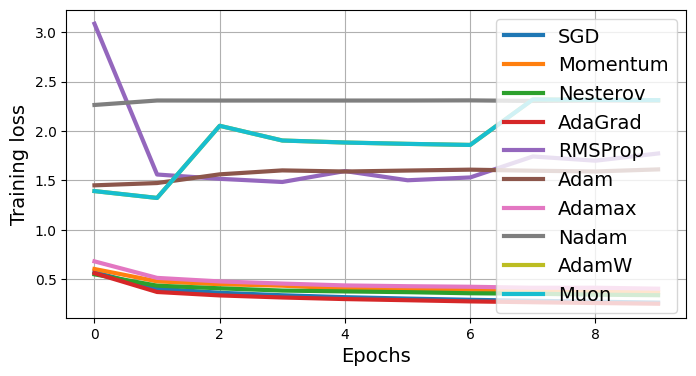

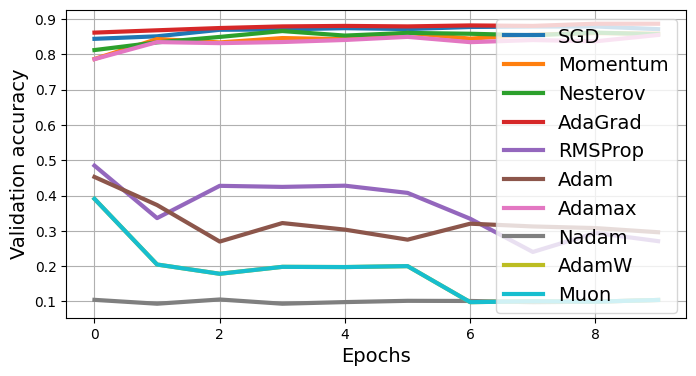

In [60]:
# extra code – visualize the learning curves of all the optimizers

for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW Muon"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw, history_muon), opt_names.split()):
        plt.plot(history[plot], label=opt_name, linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training loss", "valid_metrics": "Validation accuracy"}[plot])
    plt.legend(loc="upper right")
    plt.show()

# Learning Rate Scheduling